<h1>Clustering</h1>

In [41]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyod.models.knn import KNN
from kneed import KneeLocator
from yellowbrick.cluster import SilhouetteVisualizer
from scipy.cluster.hierarchy import fcluster

In [2]:
data = pd.read_csv('../data/final_spotify_tracks.csv')
data.set_index(['title'], inplace=True)
data.head()

,artist,top genre,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",Train,POP,3.693075,78.0,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83
Love The Way You Lie,Eminem,HIPHOP,44.814807,94.0,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82
TiK ToK,Kesha,POP,6.410236,81.0,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80
Bad Romance,Lady Gaga,POP,17.680180,89.0,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79
Just the Way You Are,Bruno Mars,POP,31.020064,93.0,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78


In [3]:
genres = data['top genre'].values

Since all of the clustering algorithms can work only with numeric data, I am not going to use the categorical attributes for clustering.

In [4]:
data.drop(['artist', 'top genre', 'year'], axis=1, inplace=True)

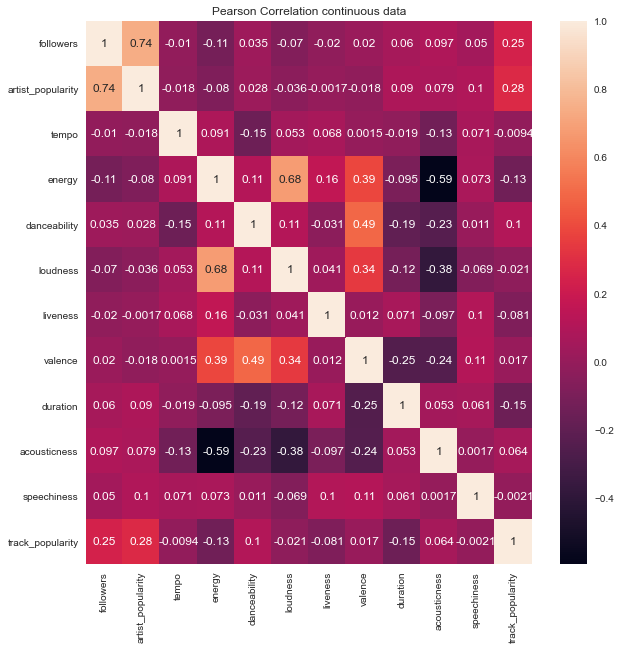

In [5]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot=True)
plt.title('Pearson Correlation continuous data')
plt.show()

The variables followers and artist_popularity have a high positive correlation of 0.74. They carry a lot of the same information, maybe we should drop one to not bias the clustering toward that attribute.

In [6]:
data.drop(['artist_popularity'], axis=1, inplace=True)

In [7]:
scaler = StandardScaler()
data[data.columns] = scaler.fit_transform(data)
data

,followers,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
title,,,,,,,,,,,
"Hey, Soul Sister",-0.821961,-0.894579,1.180111,0.148635,0.872966,-0.737832,1.227401,-0.166341,0.176541,-0.589843,1.054889
Love The Way You Lie,1.701562,-1.304649,1.426971,0.754609,0.307914,2.526270,0.511658,1.158459,0.409739,1.803688,0.985591
TiK ToK,-0.655216,0.048585,0.871535,0.830356,1.438017,0.820035,0.824796,-0.655940,-0.243214,0.669910,0.846994
Bad Romance,0.036388,0.007577,1.365256,0.375876,0.872966,-0.737832,0.824796,2.080059,-0.709610,-0.589843,0.777695
Just the Way You Are,0.855018,-0.402493,0.871535,-0.078605,0.307914,-0.663648,-0.427754,-0.051141,-0.616331,-0.589843,0.708397
...,...,...,...,...,...,...,...,...,...,...,...
Lucid Dreams,0.047284,-1.431648,-0.819456,-1.055737,-0.952151,1.190956,-1.376114,0.491336,0.918110,1.425762,1.262785
Stuck with U (with Justin Bieber),2.871170,2.458366,-1.535351,-0.404315,-0.628941,1.502529,0.050899,0.164341,0.330452,-0.567167,1.193486
If the World Was Ending - feat. Julia Michaels,-1.032629,-1.763888,-1.393406,-1.411747,-2.565938,-0.522698,0.350616,-0.405755,3.329375,0.531337,1.124188


Since the clustering results with K-means are sensitive to outliers and some variants of hierarchical clustering also, I am going to use KNN based multivariate outlier detector to remove these outliers.

In [8]:
data = data.fillna(data.median())

Inpute missing values with the median since the features have a skewed distribution.

In [9]:
knn_outlier_detector = KNN(contamination=0.05, n_neighbors=2, method='mean')

In [10]:
outliers = knn_outlier_detector.fit_predict(data)

C:\Users\mimi_\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [11]:
data['Outlier'] = outliers

The data points labeled with 0 are not outliers, the ones labeled with 1 were detected as outliers. I am going to retain only the non-outliers.

In [12]:
data_no_outliers = data[data['Outlier']==0]
data_no_outliers.drop(['Outlier'], axis=1, inplace=True)

C:\Users\mimi_\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Perform dimensionality reduction to plot the data in 2D.

In [13]:
pca = PCA(n_components=2)
decomposed_features = pca.fit_transform(data_no_outliers)

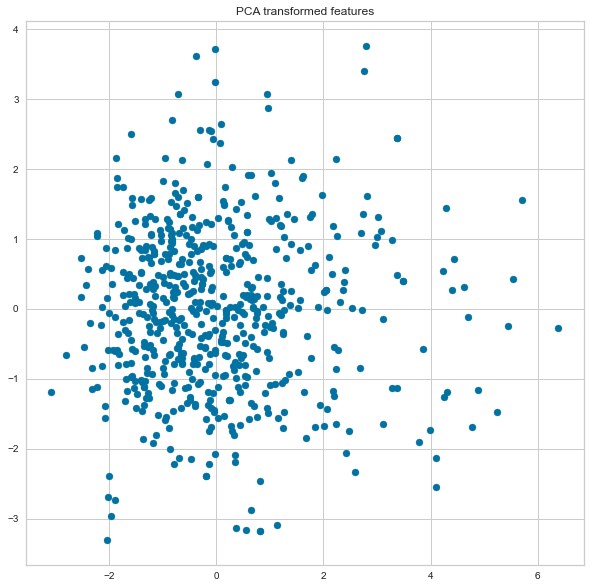

In [14]:
plt.figure(figsize=(10,10))
plt.scatter(decomposed_features[:, 0], decomposed_features[:, 1])
plt.title('PCA transformed features')
plt.show()

Some density differences are visible in the data. Maybe DBSCAN would be able to find some meaningfull clusters. K-means will probably not find a good clustering.

<h3>1. K-mean clustering</h3>

Defining a function to make a scatter plot of the data with respect to the clustering labels.

In [15]:
def plot_clusters(data, labels, title, centroids=None):
  sns.set_style("whitegrid")
  plt.figure(figsize=(7,5))
  sns.scatterplot(x=data[:,0], y=data[:,1], c=labels, palette=sns.color_palette("Set1", n_colors=8, desat=.5), ax=plt.gca())
  if centroids is not None:
    sns.scatterplot(x=centroids[:,0], y=centroids[:,1], marker="x", color="blue", s=200, ax=plt.gca())
  plt.title(title)
  plt.show()

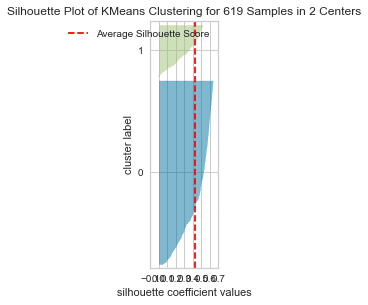

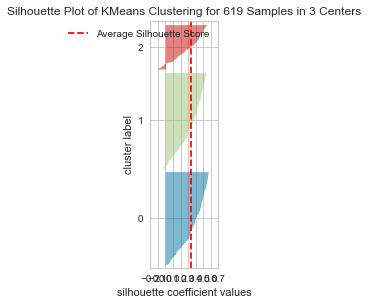

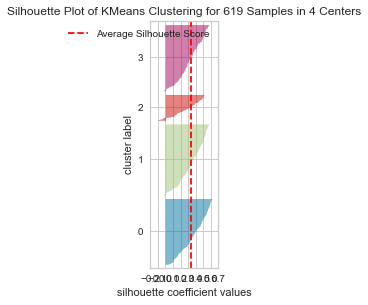

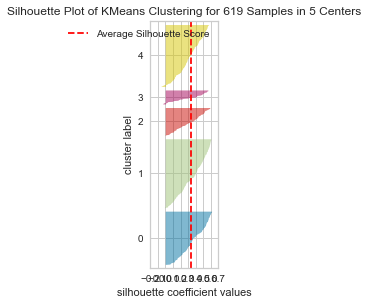

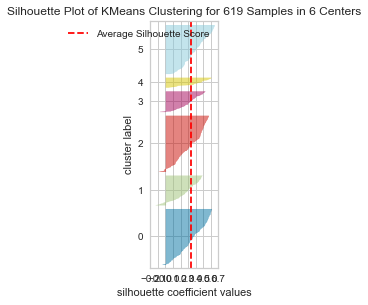

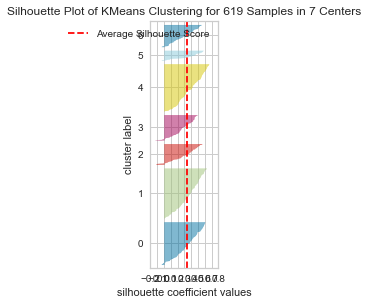

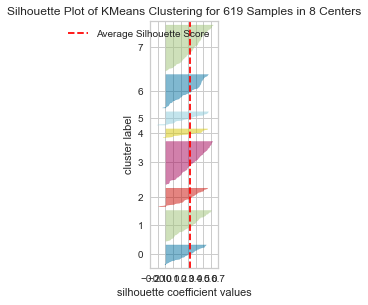

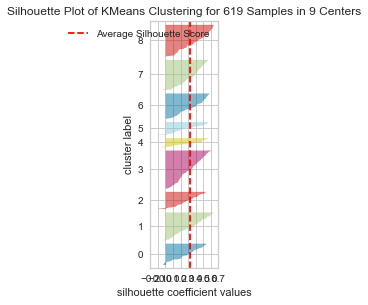

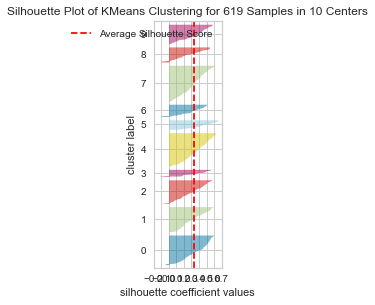

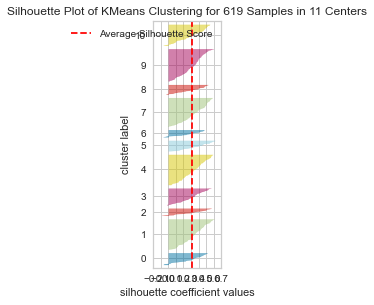

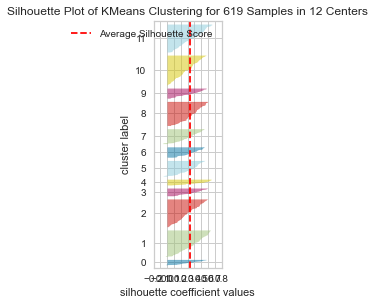

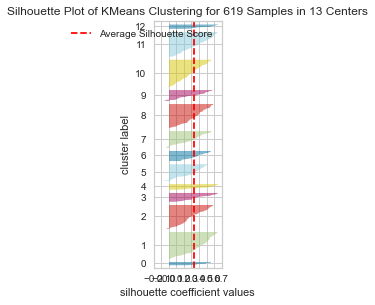

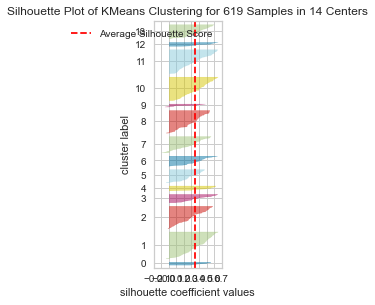

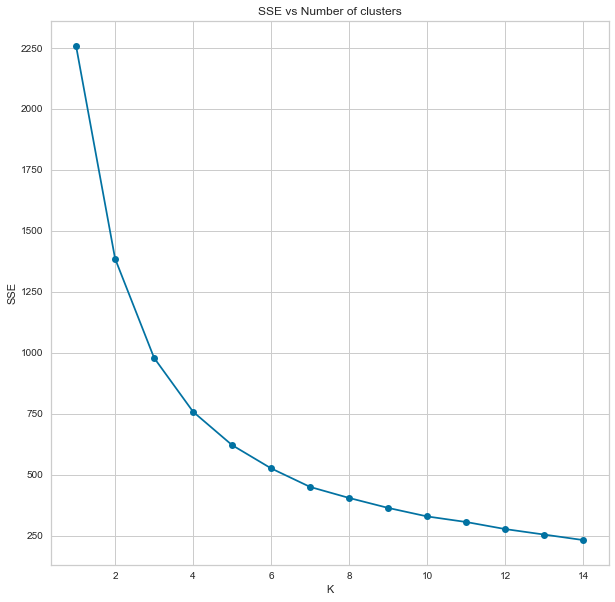

In [16]:
num_clusters = range(1, 15)
SSE = []
silhouette_coefficients = []
for k in num_clusters:
  kmeans = KMeans(n_clusters=k, max_iter=150, random_state=0)
  kmeans.fit(decomposed_features)
  SSE.append(kmeans.inertia_)
  if k != 1:
    score = silhouette_score(decomposed_features, kmeans.labels_)
    silhouette_coefficients.append(score)
    plt.figure(figsize=(10,10))
    plt.subplot(2, 7, k)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=plt.gca())
    visualizer.fit(decomposed_features)
    visualizer.show()
    plt.show()

plt.figure(figsize=(10,10))
plt.plot(range(1, 15), SSE, marker='o');
plt.xlabel('K'); 
plt.ylabel('SSE')
plt.title('SSE vs Number of clusters')
plt.show()

In [17]:
kl = KneeLocator(range(1, 15), SSE, curve="convex", direction="decreasing")
kl.elbow

4

The sharp lowering of the sum of squared errors is at 4 clusters, after that the lowering is insignificant at each step. Also from the silhouette plots, we can see that no clustering is optimal, but from the given clusters 4 would be most suitable for this problem. So I'm going to choose 4 clusters.

Let's visualize the clusters. K-means has a tendention for globular, equally sized clusters.

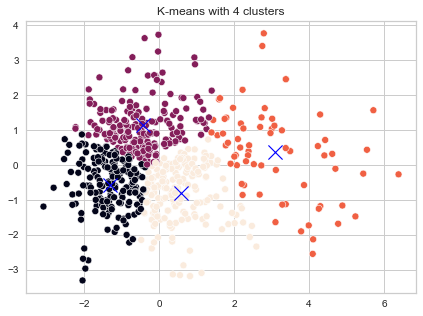

In [86]:
kmeans = KMeans(n_clusters=4, max_iter=150, random_state=0)
kmeans.fit(decomposed_features)
plot_clusters(decomposed_features, kmeans.labels_, "K-means with 4 clusters", kmeans.
cluster_centers_)

In [37]:
silhouette_coefficients[2]

0.33720863826162917

The value of the silhouette coefficient for this clustering is almost 0.34 which implies that the clusters are not well separated, which is visible from the plot.

<h3>2. Hierarchical Clustering</h3>

In [20]:
results = []
for num_clust in range(2, 16):
  for link in ["ward", "complete", "average", "single"]:
    node = {}
    agglomerative = AgglomerativeClustering(n_clusters=num_clust, linkage=link)
    agglomerative.fit(decomposed_features)
    node['num_clusters'] = num_clust
    node['linkage'] = link
    node['silhouette score'] = silhouette_score(decomposed_features, agglomerative.labels_)
    node['variance ratio'] = calinski_harabasz_score(decomposed_features, agglomerative.labels_)
    results.append(node)
results = pd.DataFrame(results)

In [21]:
results

,num_clusters,linkage,silhouette score,variance ratio
0,2,ward,0.449759,319.374688
1,2,complete,0.531796,181.446075
2,2,average,0.544389,181.728478
3,2,single,0.578382,9.760349
4,3,ward,0.301105,335.605850
5,3,complete,0.239567,232.113198
6,3,average,0.484590,103.064654
7,3,single,0.470340,10.793680
8,4,ward,0.297149,341.956789
9,4,complete,0.252962,221.516253


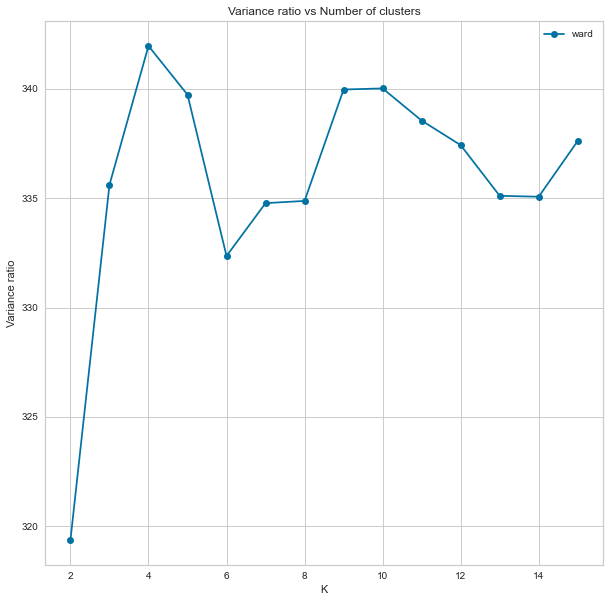

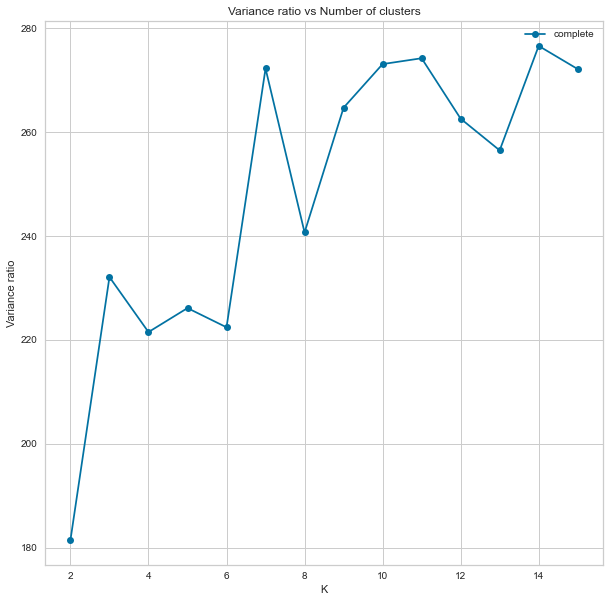

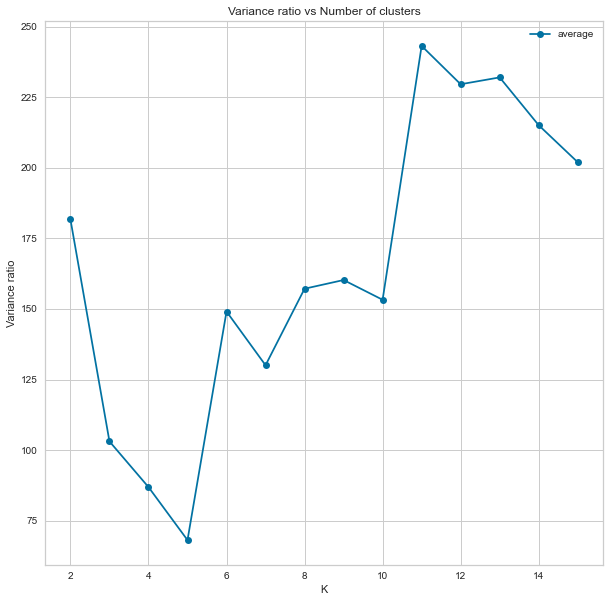

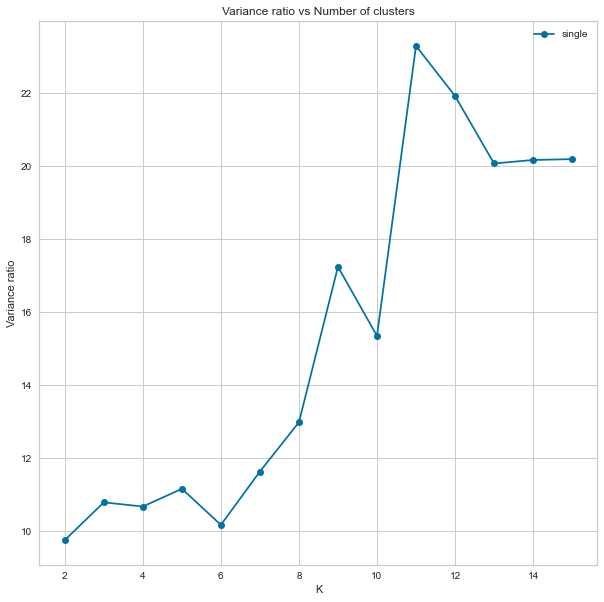

In [22]:
for link in ["ward", "complete", "average", "single"]:
  plt.figure(figsize=(10,10))
  plt.plot(range(2,16), results[results['linkage']==link]['variance ratio'], marker='o', label=link);
  plt.xlabel('K'); 
  plt.ylabel('Variance ratio');
  plt.title('Variance ratio vs Number of clusters')
  plt.legend()
  plt.show()

Single link produces the lowest variance ratio values whereas ward's method produces the largest values. But the variance ratio is higher for convex clusters such as those generated for K-meas, and ward's method is the hierarchical equivalent to K-means. The highest value is for ward with 4 clusters.

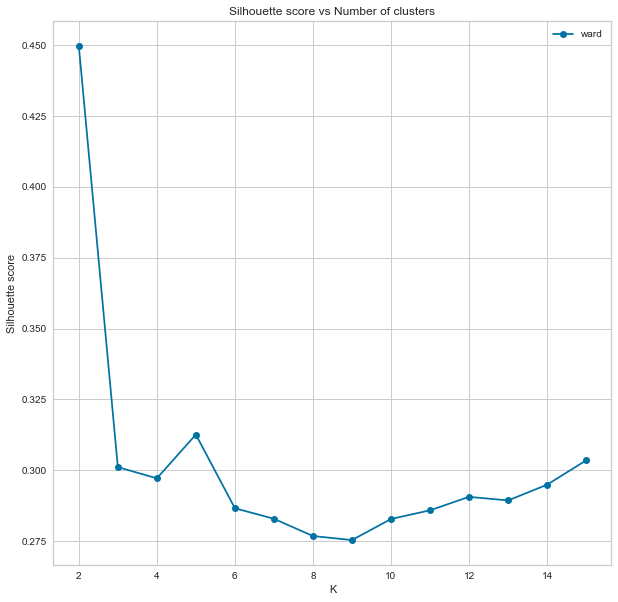

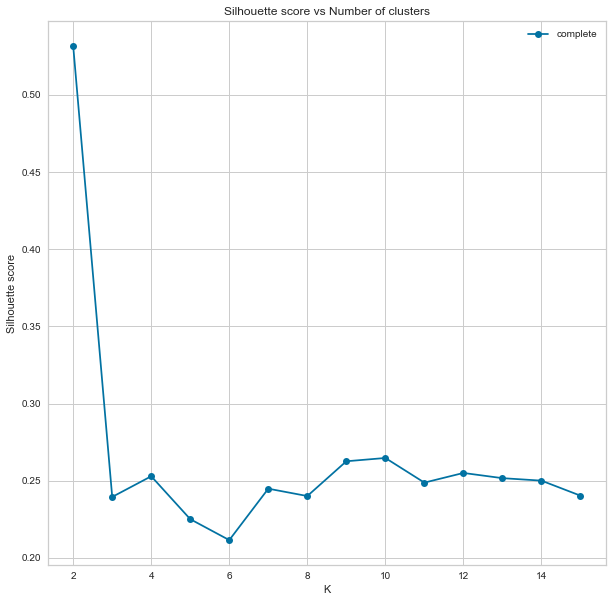

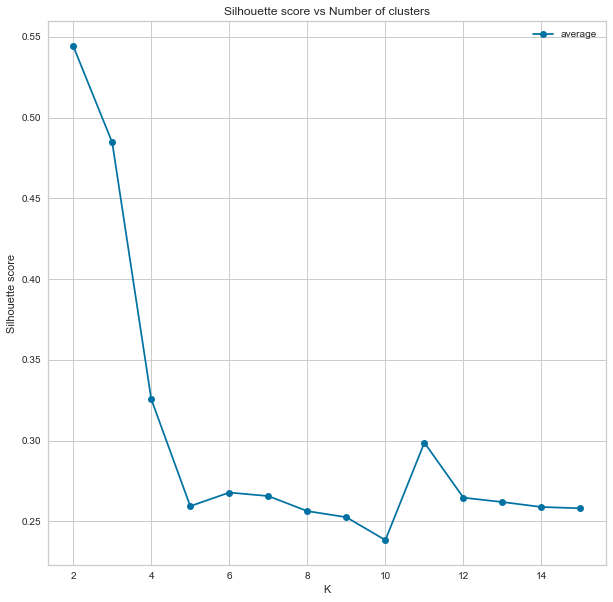

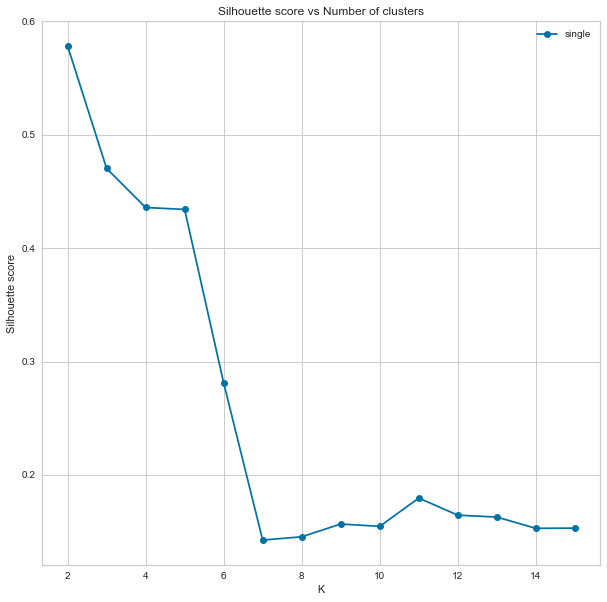

In [23]:
for link in ["ward", "complete", "average", "single"]:
  plt.figure(figsize=(10,10))
  plt.plot(range(2,16), results[results['linkage']==link]['silhouette score'], marker='o', label=link);
  plt.xlabel('K'); 
  plt.ylabel('Silhouette score');
  plt.title('Silhouette score vs Number of clusters')
  plt.legend()
  plt.show()

Since the single link clustering is continguity based, then the final 2 clusters may consist of num_datapoints - 1 and 1. That's why for these values, the variance ratio is low but the silhouette coefficient is high.I am going to choose wards method since it has the highest variance ratio with 4 clusters because 2 is too much of an overfit.

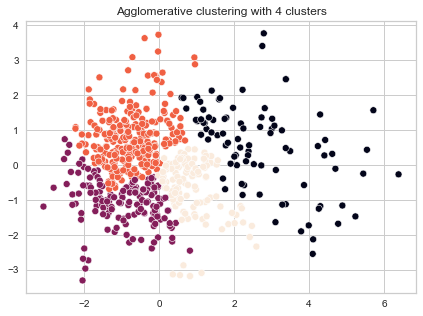

In [39]:
agglomerative = AgglomerativeClustering(n_clusters=4, linkage='ward')
agglomerative.fit(decomposed_features)
plot_clusters(decomposed_features, agglomerative.labels_, "Agglomerative clustering with 4 clusters")

Let's visualize the hierarchical grouping of the first 50 songs.

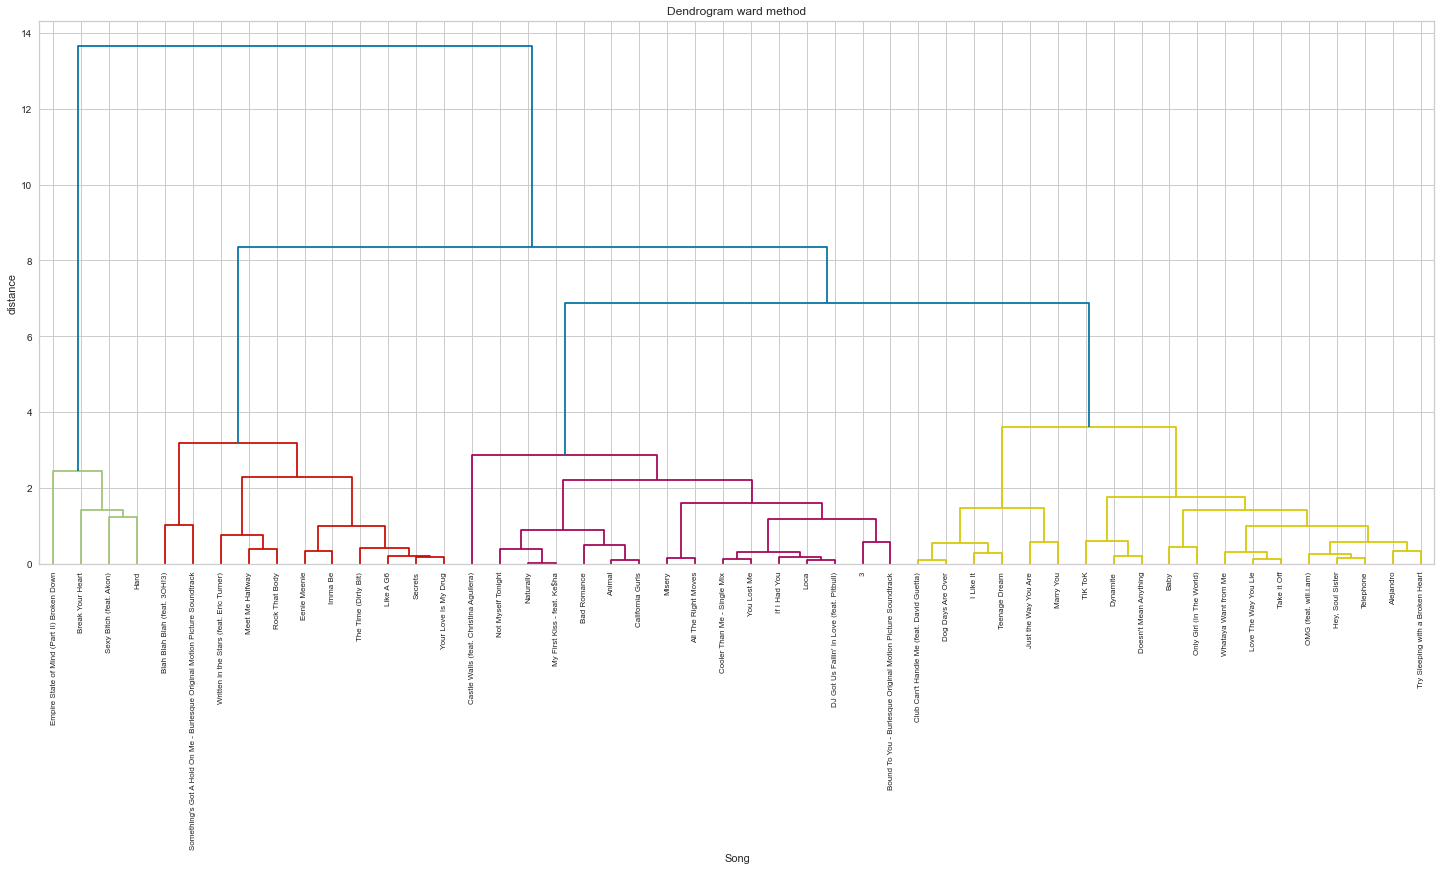

In [49]:
Z = linkage(decomposed_features[:50], 'ward')
fig = plt.figure(figsize=(25, 10))
plt.title('Dendrogram ward method')
plt.xlabel('Song')
plt.xticks(ticks = range(0, 50), labels=data.index[:50].tolist(), rotation=90)
plt.ylabel('distance')
from scipy.cluster.hierarchy import cut_tree
dendrogram(Z, leaf_rotation=90., color_threshold=4, leaf_font_size=8., ax=plt.gca(), labels=data.index[:50].tolist());
plt.show()

We can clearly see that the cluster sizes are different. The first cluster has songs that are more live. The second one has songs that are calmer in general. 

<h3>3. DBSCAN</h3>

In [26]:
from sklearn.neighbors import NearestNeighbors

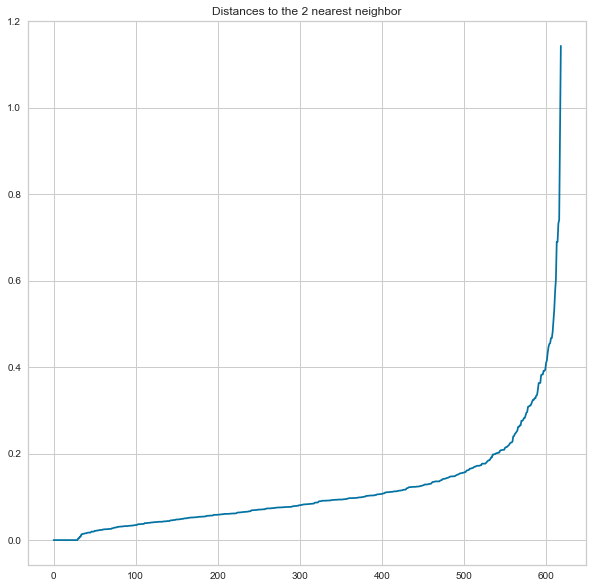

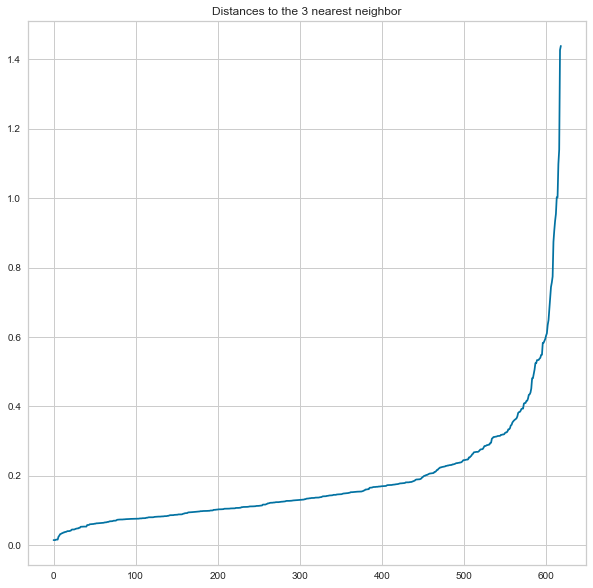

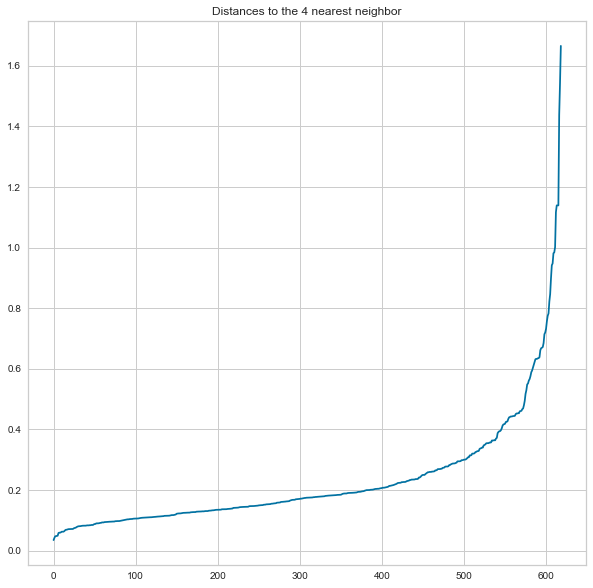

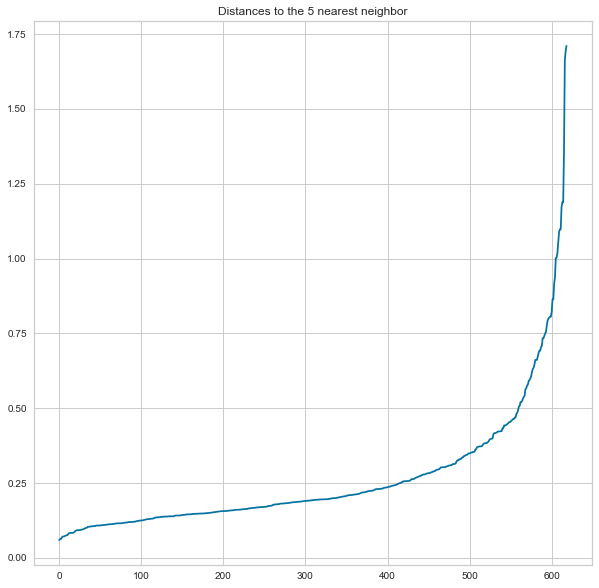

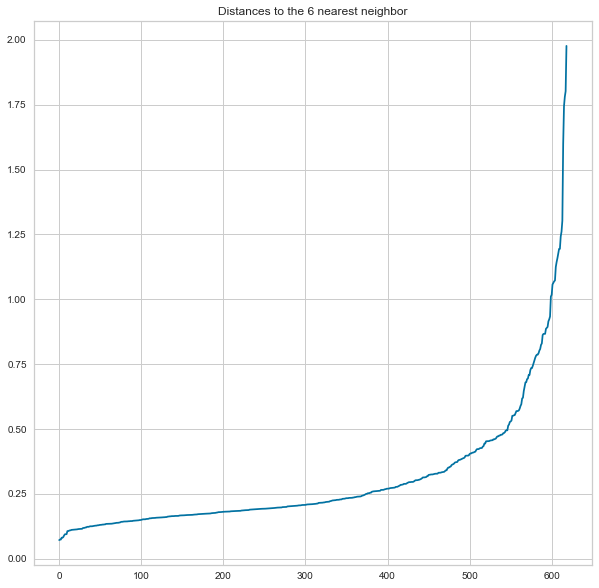

In [27]:
d_list = []
distances = []
neighbors = [2, 3, 4, 5, 6]
for n in neighbors:
    neigh = NearestNeighbors(n_neighbors=n)
    nbrs = neigh.fit(decomposed_features)
    distances, indices = nbrs.kneighbors(decomposed_features)
    distances = np.sort(distances, axis=0)
    distances = distances[:, n-1]
    d_list.append(distances)

    plt.figure(figsize=(10,10))
    plt.plot(distances);
    plt.title('Distances to the ' + str(n) + ' nearest neighbor')
    plt.show()

The values for all neighbors are not very different. I am going to choose 2 neighbors.

In [80]:
kl = KneeLocator(range(1, len(decomposed_features)+1), d_list[0], curve="convex", direction="increasing")

In [81]:
kl.elbow

615

In [82]:
eps = d_list[0][kl.elbow]
eps

0.7324637674182721

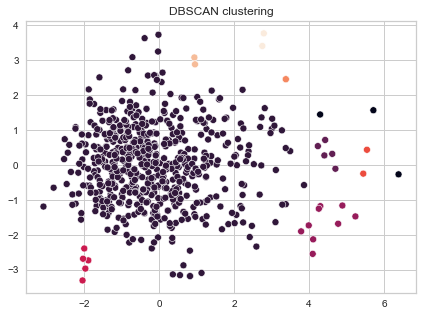

In [83]:
dbscan = DBSCAN(eps=eps, min_samples=2).fit(decomposed_features)
plot_clusters(decomposed_features, dbscan.labels_, 'DBSCAN clustering')

In [84]:
silhouette_score(decomposed_features, dbscan.labels_)

0.17901284401960946

In [85]:
calinski_harabasz_score(decomposed_features, dbscan.labels_)

28.932312910650833

It seems like DBSCAN is detecting one cluster in the dense region and the other points that are clustered together look more like outliers, but this is due to the lower density in those regions. It does not work quite well.